# Carregando Dados Experimentais

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.signal import resample
import itertools

In [49]:
def extract_data(path, files, skip_rows):
    df = pd.concat((pd.read_csv(path + files[f] + '.csv', skiprows=[i for i in range(1, skip_rows)]).assign(filename=f) for f in range(len(files))), ignore_index=True)
    df.columns.values[:] = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'label']

    return df

In [50]:
files =  ['struct_rs_R1.mat_torque05', 'struct_rs_R1.mat_torque10', 'struct_rs_R1.mat_torque15', 'struct_rs_R1.mat_torque20', 'struct_rs_R1.mat_torque25','struct_rs_R1.mat_torque30', 'struct_rs_R1.mat_torque35', 'struct_rs_R1.mat_torque40', 
          'struct_r1b_R1.mat_torque05', 'struct_r1b_R1.mat_torque10', 'struct_r1b_R1.mat_torque15', 'struct_r1b_R1.mat_torque20', 'struct_r1b_R1.mat_torque25','struct_r1b_R1.mat_torque30', 'struct_r1b_R1.mat_torque35', 'struct_r1b_R1.mat_torque40',
          'struct_r2b_R1.mat_torque05', 'struct_r2b_R1.mat_torque10', 'struct_r2b_R1.mat_torque15', 'struct_r2b_R1.mat_torque20', 'struct_r2b_R1.mat_torque25','struct_r2b_R1.mat_torque30', 'struct_r2b_R1.mat_torque35', 'struct_r2b_R1.mat_torque40',
          'struct_r3b_R1.mat_torque05', 'struct_r3b_R1.mat_torque10', 'struct_r3b_R1.mat_torque15', 'struct_r3b_R1.mat_torque20', 'struct_r3b_R1.mat_torque25','struct_r3b_R1.mat_torque30', 'struct_r3b_R1.mat_torque35', 'struct_r3b_R1.mat_torque40',
          'struct_r4b_R1.mat_torque05', 'struct_r4b_R1.mat_torque10', 'struct_r4b_R1.mat_torque15', 'struct_r2b_R1.mat_torque20', 'struct_r2b_R1.mat_torque25','struct_r2b_R1.mat_torque30', 'struct_r2b_R1.mat_torque35', 'struct_r2b_R1.mat_torque40']
path = 'C:/Users/vinic/Desktop/LXL/USP/Dataset_USP_CSV/'


df = extract_data(path=path, files=files, skip_rows=194657)


# Resample 833 pontos por ciclo para 128

df0 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 3]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df0 = np.concatenate([resample(df0[i], 128).reshape(1, -1) for i in range(df0.shape[0])], axis=0)

df1 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 4]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df1 = np.concatenate([resample(df1[i], 128).reshape(1, -1) for i in range(df1.shape[0])], axis=0)

df2 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 5]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df2 = np.concatenate([resample(df2[i], 128).reshape(1, -1) for i in range(df2.shape[0])], axis=0)


# Concatena todos os valores extraidos em uma unica matriz
datasetCon = np.concatenate((df0, df1, df2), axis=1)

# Adiciona os Labels
labels = np.concatenate([np.full((968, 1), i, dtype=int) for i in range(40)], axis=0)

datasetCon = np.concatenate((datasetCon, labels),axis=1)

# Treino, Teste e Validação

In [51]:
""" Aplicando one-hot-encoding, as categorias se transformam em colunas (variáveis) onde o 
número 1 representa o valor afirmativo e o 0 negativo. 
https://arthurlambletvaz.medium.com/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0 """

"""60% - Treino, 20% - Validação, 20% - Teste"""

# Coleta os dados das entradas datasetCon (ficando de fora os dados do One-hot-encoder)
x_datasetCon = datasetCon[:, :-1]

# Coleta os dados das saídas
y_datasetCon = datasetCon[:, -1]

# Separa os dados de entrada e saida para treino e testes
x_train,x_temp,y_train,y_temp = train_test_split(x_datasetCon,y_datasetCon, test_size=0.3, random_state=42, shuffle=True, stratify=y_datasetCon)
x_test,x_validation,y_test,y_validation = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp)



"""Tamanho do teste e Validação (X, Y)"""

# Treino
print(x_train.shape, y_train.shape)

# Validação
print(x_validation.shape, y_validation.shape)

# Test
print(x_test.shape, y_test.shape)

"""Normalização"""

scaler  = MinMaxScaler(feature_range=(0,1)) # Tangente Hiperbólica ou outro análoga

x_train       = scaler.fit_transform(x_train)
x_validation  = scaler.fit_transform(x_validation)
x_test        = scaler.fit_transform(x_test)

(27104, 384) (27104,)
(5808, 384) (5808,)
(5808, 384) (5808,)


In [52]:
## Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv1D, SpatialDropout1D, Dropout, MaxPooling1D, BatchNormalization, Dense, Flatten, LSTM, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, L1L2
from tensorflow.keras.constraints import unit_norm

# Optuna

In [53]:
import optuna

c:\Users\vinic\.conda\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
class Objective(object):
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
 
    def __call__(self, trial):
        
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96]) # Batch Size
       
        drop_out=trial.suggest_float('drop_out', 0.0, 0.1, step=0.05, log=False) # Dropout

        lr = trial.suggest_float("lr", 2.5e-4, 2.5e-3, log=True) # Learning Rate


                          
        dict_params = {'batch_size':batch_size,
                       'drop_out':drop_out,                       
                       'lr':lr}
                                              
        # Começo da CNN
        inputs = Input((x_train.shape[1],1))
         
        # Primeira camada convolucional
        Conv = Conv1D(filters=32, 
                    kernel_size=6, 
                    strides=1, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(inputs)

        Conv = keras.layers.SpatialDropout1D(dict_params['drop_out'])(Conv)
        Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
        Conv = BatchNormalization()(Conv)
         
        # Segunda camada convolucional
        Conv = Conv1D(filters=32, 
                    kernel_size=6, 
                    strides=1, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

        Conv = keras.layers.SpatialDropout1D(dict_params['drop_out'])(Conv)
        Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
        Conv = BatchNormalization()(Conv)

        # Terceira camada convolucional
        Conv = Conv1D(filters=32, 
                    kernel_size=6, 
                    strides=1, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

        Conv = keras.layers.SpatialDropout1D(dict_params['drop_out'])(Conv)
        Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
        Conv = BatchNormalization()(Conv)
                         
        # Flatten
        dense = Flatten()(Conv)
        
        # Primeira camada densa
        dense = Dense(units=512, 
                    activation='relu',
                    kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
        dense = keras.layers.Dropout(dict_params['drop_out'])(dense)


        # Segunda camada densa
        dense = Dense(units=64, 
                    activation='relu',
                    kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
        dense = keras.layers.Dropout(dict_params['drop_out'])(dense)
        
        # Camda de saída
        dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
         
        
        
        # instantiate and compile model
        model = Model(inputs, dense)
        opt = Adam(learning_rate = lr)


        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])
        


        """ Callbacks """

        # Check Point
        checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

        # Early Stopping
        earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-3, patience=15, mode='auto', restore_best_weights=True)

        # Reduce LR
        reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, mode="auto", min_delta=1e-3, cooldown=0, min_lr=0)

             
        # fit the model
        history = model.fit(x_train, y_train, epochs=self.max_epochs,
                            validation_data=(x_validation, y_validation),
                            batch_size=batch_size, 
                            callbacks=[[checkpoint_cb, earlystopping, reduceLR]])
                 
        # Evaluate the model accuracy on the test set.
        score = model.evaluate(x_test, y_test)
                 
        return score[1]

In [55]:
maximum_epochs = 70

maximum_time = 20*60*60  # seconds
 
objective = Objective(maximum_epochs)
 
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
 
study.optimize(objective, timeout=maximum_time)
 
# save results
df_results = study.trials_dataframe()

trial_CNN = study.best_trial

print('CC: {}'.format(trial_CNN.value))
print("Best hyperparameters: {}".format(trial_CNN.params))

Epoch 1/70
283/283 [==============================] - 19s 53ms/step - loss: 3.3036 - acc: 0.2554 - val_loss: 7.5494 - val_acc: 0.0250 - lr: 0.0023
Epoch 2/70
283/283 [==============================] - 14s 50ms/step - loss: 2.0119 - acc: 0.3987 - val_loss: 2.5161 - val_acc: 0.2429 - lr: 0.0023
Epoch 3/70
283/283 [==============================] - 14s 49ms/step - loss: 1.7238 - acc: 0.4680 - val_loss: 1.4956 - val_acc: 0.5558 - lr: 0.0023
Epoch 4/70
283/283 [==============================] - 13s 45ms/step - loss: 1.5866 - acc: 0.5081 - val_loss: 1.4770 - val_acc: 0.5217 - lr: 0.0023
Epoch 5/70
283/283 [==============================] - 13s 46ms/step - loss: 1.5196 - acc: 0.5272 - val_loss: 1.4016 - val_acc: 0.5584 - lr: 0.0023
Epoch 6/70
283/283 [==============================] - 15s 53ms/step - loss: 1.4452 - acc: 0.5514 - val_loss: 1.4138 - val_acc: 0.5597 - lr: 0.0023
Epoch 7/70
283/283 [==============================] - 14s 48ms/step - loss: 1.3850 - acc: 0.5687 - val_loss: 1.3933 - 

In [56]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial_CNN

print("  Value: ", trial_CNN.value)

print("  Params: ")
for key, value in trial_CNN.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  49
Best trial:
  Value:  0.8428030014038086
  Params: 
    batch_size: 64
    drop_out: 0.05
    lr: 0.0002623826405794159


In [57]:
optuna.visualization.plot_optimization_history(study)

In [58]:
optuna.visualization.plot_slice(study)

In [59]:
optuna.visualization.plot_param_importances(study)

# Teste

In [60]:
# Começo da CNN
inputs = Input((x_train.shape[1],1))
    
# Primeira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(inputs)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
    
# Segunda camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)

# Terceira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
                    
# Flatten
dense = Flatten()(Conv)

# Primeira camada densa
dense = Dense(units=512, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
            activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
dense = keras.layers.Dropout(0.05)(dense)


# Segunda camada densa
dense = Dense(units=64, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
            activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
dense = keras.layers.Dropout(0.05)(dense)

# Camda de saída
dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
    


# instantiate and compile model
model = Model(inputs, dense)
opt = Adam(learning_rate = 0.000262)


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])



""" Callbacks """

# Check Point
checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

# Early Stopping
earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-3, patience=15, mode='auto', restore_best_weights=True)

# Reduce LR
reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, mode="auto", min_delta=1e-3, cooldown=0, min_lr=0)

        
# fit the model
history = model.fit(x_train, y_train, epochs=300,
                    validation_data=(x_validation, y_validation),
                    batch_size=64, 
                    callbacks=[[checkpoint_cb, 
                                #earlystopping, 
                                reduceLR]])
            
# Evaluate the model accuracy on the test set.
score = model.evaluate(x_test, y_test)

Epoch 1/300
424/424 [==============================] - 31s 69ms/step - loss: 4.5626 - acc: 0.2141 - val_loss: 8.8767 - val_acc: 0.0250 - lr: 2.6200e-04
Epoch 2/300
424/424 [==============================] - 35s 83ms/step - loss: 3.4984 - acc: 0.3302 - val_loss: 3.3919 - val_acc: 0.2836 - lr: 2.6200e-04
Epoch 3/300
424/424 [==============================] - 33s 79ms/step - loss: 2.8995 - acc: 0.4065 - val_loss: 2.5469 - val_acc: 0.4768 - lr: 2.6200e-04
Epoch 4/300
424/424 [==============================] - 32s 77ms/step - loss: 2.4937 - acc: 0.4622 - val_loss: 2.2181 - val_acc: 0.5275 - lr: 2.6200e-04
Epoch 5/300
424/424 [==============================] - 33s 77ms/step - loss: 2.2034 - acc: 0.5018 - val_loss: 1.9772 - val_acc: 0.5763 - lr: 2.6200e-04
Epoch 6/300
424/424 [==============================] - 33s 78ms/step - loss: 1.9661 - acc: 0.5394 - val_loss: 1.7670 - val_acc: 0.6024 - lr: 2.6200e-04
Epoch 7/300
424/424 [==============================] - 33s 79ms/step - loss: 1.7961 - ac

In [61]:
# **Função para salvar plot**
def plot_loss_acc(history,more_title='', nameLoss="Loss", nameAccuracy="Accuracy"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, 'r', label='Treino loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Loss Treino e Validação' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig(nameLoss+".png", format='png')
    plt.show()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'r', label='Treino acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy Treino e Validação' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig(nameAccuracy+".png", format='png')
    plt.show()

    print(more_title + 'Accuracy Treino: {:.3f} %, Accuracy Validação: {:.2f} %'.format(acc[len(acc)-1] *100, val_acc[len(val_acc)-1]*100))
    print(more_title + 'Loss Treino: {:.3f} %, Loss Validação: {:.2f} %'.format(loss[len(loss)-1] *100, val_loss[len(val_loss)-1]*100))

    return loss, val_loss, acc, val_acc

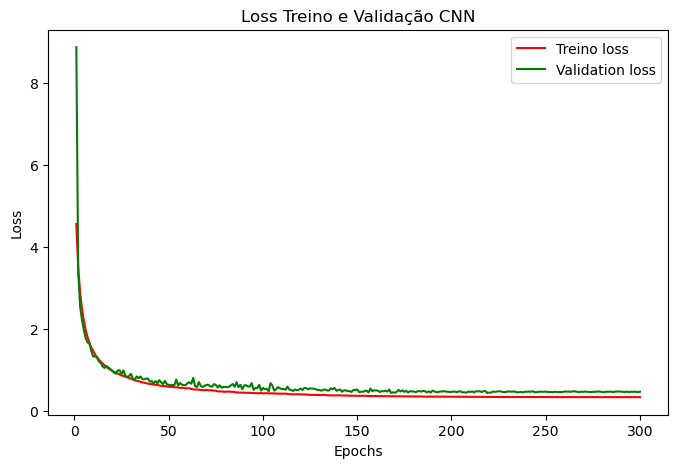

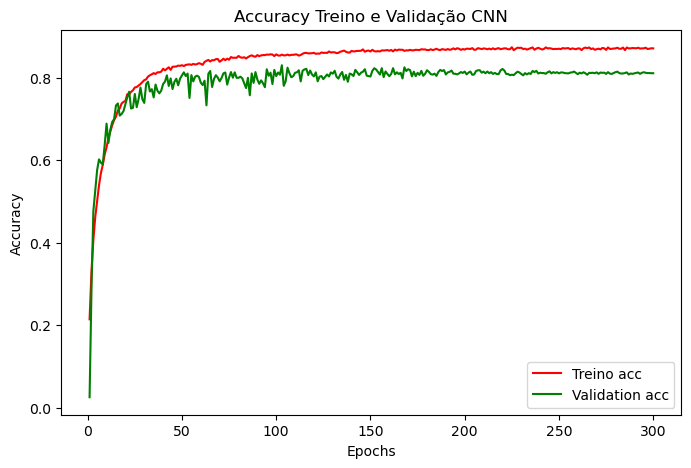

CNNAccuracy Treino: 87.190 %, Accuracy Validação: 81.16 %
CNNLoss Treino: 33.962 %, Loss Validação: 47.24 %


In [62]:
# **Plot com salvamento graficos**
loss, val_loss, acc, val_acc = plot_loss_acc(history,'CNN')

In [63]:
# **Validação da base de teste**
saida_rede = pd.DataFrame(model.predict(x_test)).round(decimals = 2)

display(saida_rede)

182/182 [==============================] - 2s 9ms/step


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,1.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00
1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,1.0,0.0,0.0,0.00,0.00,0.00
2,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.97,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.02
3,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.77,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00
5804,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.47,0.00,0.00
5805,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,...,0.97,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00
5806,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00


In [64]:
# **Acerto da rede**
predito   = saida_rede.idxmax(axis=1)
avaliado  = pd.DataFrame(y_test).iloc[:, 0]

resultado = list(avaliado.values - predito.values)
resultado = resultado.count(0) * 100 / len(resultado)

print("Porcentagem de acerto {}%".format(int(resultado)))

Porcentagem de acerto 83%


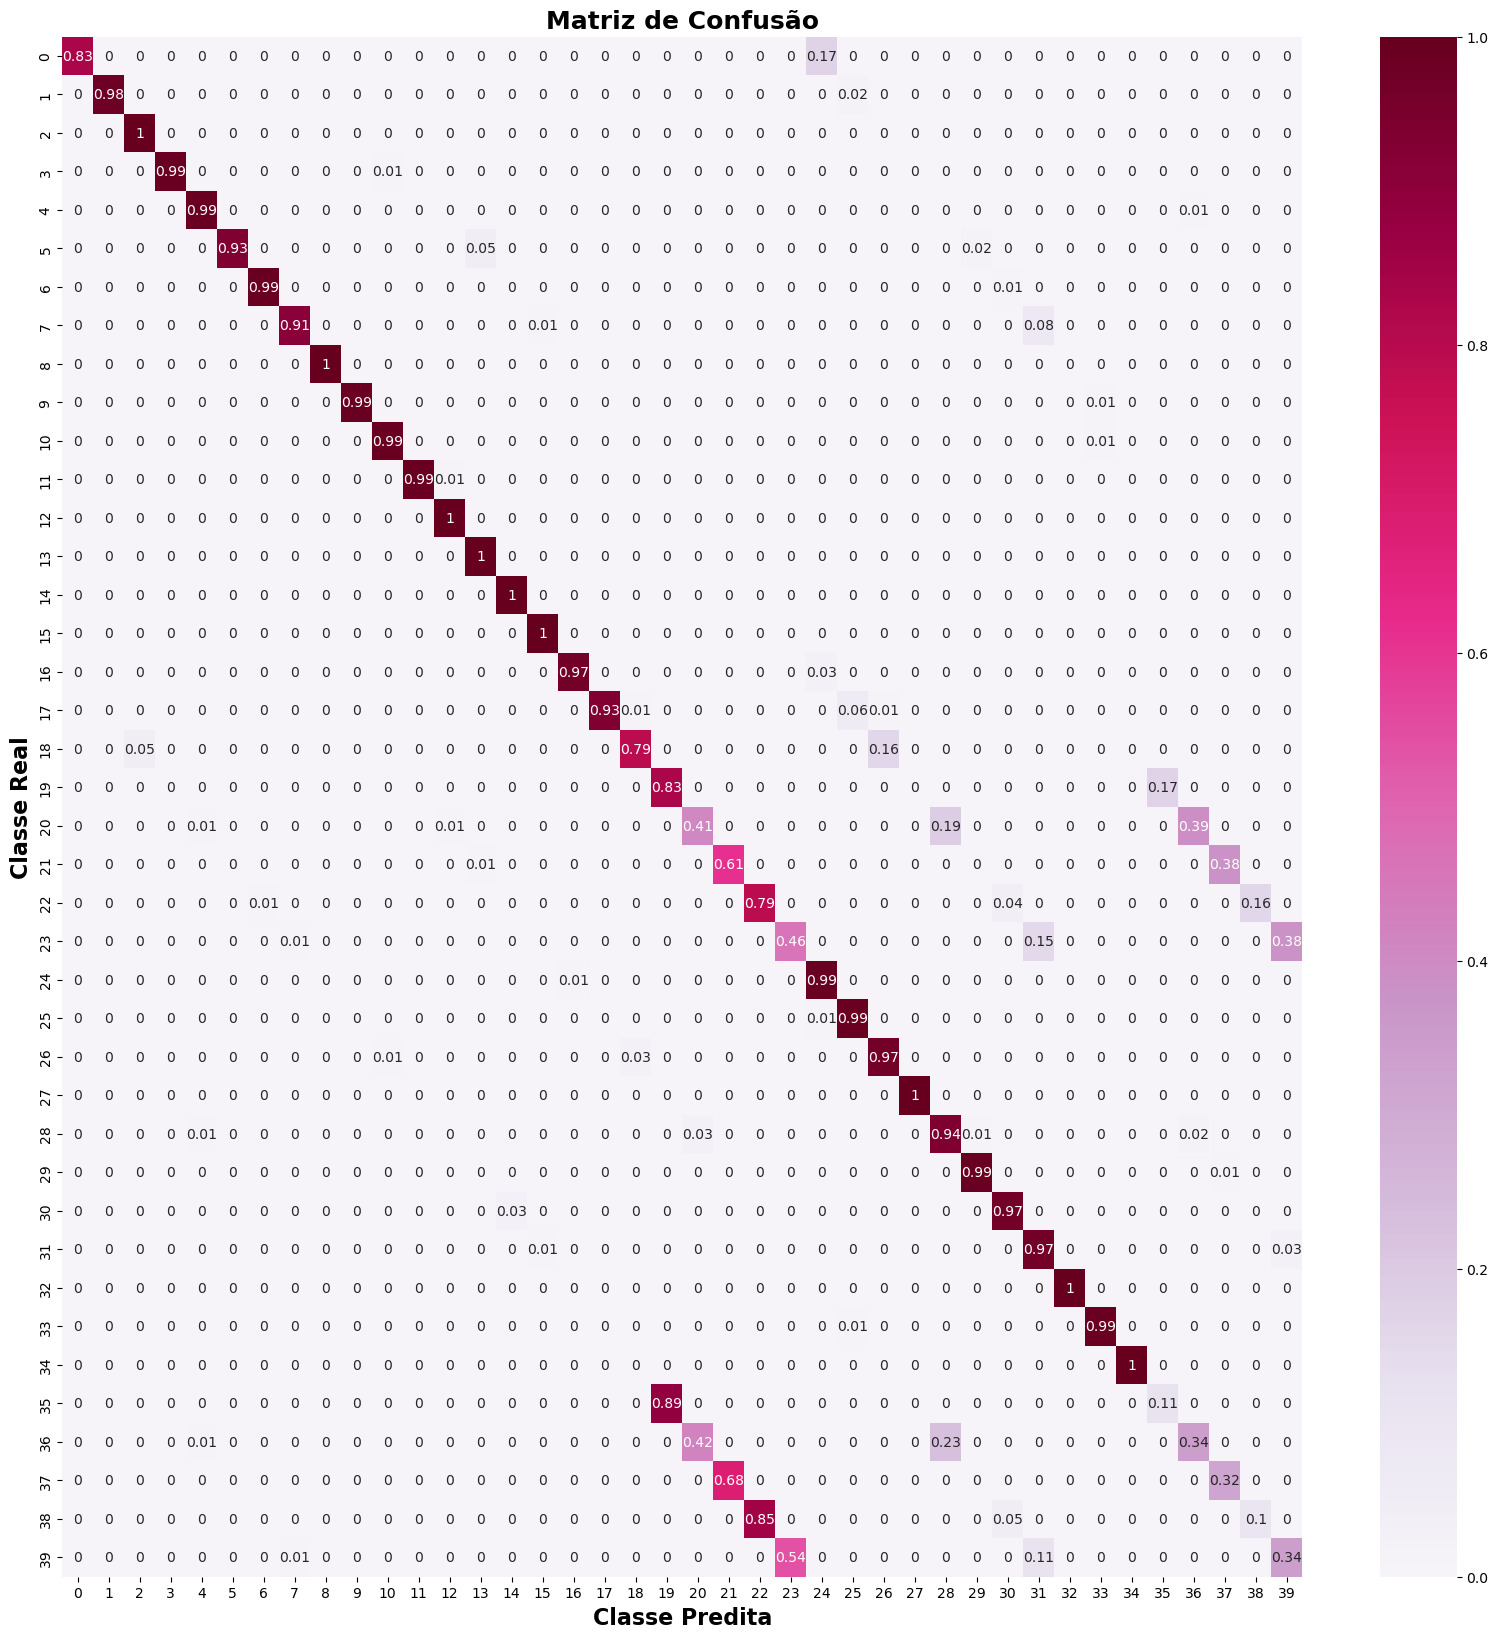

In [65]:
# **Matriz de confusão**
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(avaliado, predito)
# Normalise
cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(cmn, 
            annot=True, 
            cmap="PuRd")


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
plt.show(block=False)

In [66]:
# **Classification Report**

from sklearn.metrics import classification_report

print(classification_report(avaliado, predito))

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91       145
         1.0       1.00      0.98      0.99       145
         2.0       0.95      1.00      0.98       146
         3.0       1.00      0.99      1.00       146
         4.0       0.97      0.99      0.98       145
         5.0       1.00      0.93      0.96       145
         6.0       0.99      0.99      0.99       145
         7.0       0.99      0.91      0.95       145
         8.0       1.00      1.00      1.00       145
         9.0       1.00      0.99      0.99       145
        10.0       0.99      0.99      0.99       145
        11.0       1.00      0.99      1.00       145
        12.0       0.99      1.00      0.99       145
        13.0       0.95      1.00      0.97       145
        14.0       0.97      1.00      0.98       145
        15.0       0.99      1.00      0.99       145
        16.0       0.99      0.97      0.98       145
        17.0       1.00    

# Teste 2

In [73]:
# Começo da CNN
inputs = Input((x_train.shape[1],1))
    
# Primeira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-3, l2=1e-2),
            bias_regularizer=L1L2(l1=1e-3, l2=1e-2))(inputs)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
    
# Segunda camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-3, l2=1e-2),
            bias_regularizer=L1L2(l1=1e-3, l2=1e-2))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)

# Terceira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-3, l2=1e-2),
            bias_regularizer=L1L2(l1=1e-3, l2=1e-2))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
                    
# Flatten
dense = Flatten()(Conv)

# Primeira camada densa
dense = Dense(units=512, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-3, l2=1e-2),
            bias_regularizer=L1L2(l1=1e-3, l2=1e-2),
            activity_regularizer=L1L2(l1=1e-3, l2=1e-2))(dense)
dense = keras.layers.Dropout(0.05)(dense)


# Segunda camada densa
dense = Dense(units=64, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-3, l2=1e-2),
            bias_regularizer=L1L2(l1=1e-3, l2=1e-2),
            activity_regularizer=L1L2(l1=1e-3, l2=1e-2))(dense)
dense = keras.layers.Dropout(0.05)(dense)

# Camda de saída
dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
    


# instantiate and compile model
model = Model(inputs, dense)
opt = Adam(learning_rate = 0.000262)


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])



""" Callbacks """

# Check Point
checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

# Early Stopping
earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-2, patience=15, mode='auto', restore_best_weights=True)

# Reduce LR
reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, mode="auto", min_delta=1e-2, cooldown=0, min_lr=0)

        
# fit the model
history = model.fit(x_train, y_train, epochs=300,
                    validation_data=(x_validation, y_validation),
                    batch_size=64, 
                    callbacks=[[checkpoint_cb, 
                                #earlystopping, 
                                reduceLR]])
            
# Evaluate the model accuracy on the test set.
score = model.evaluate(x_test, y_test)

Epoch 1/300
424/424 [==============================] - 34s 76ms/step - loss: 12.0265 - acc: 0.1354 - val_loss: 6.7518 - val_acc: 0.0265 - lr: 2.6200e-04
Epoch 2/300
424/424 [==============================] - 35s 84ms/step - loss: 3.8218 - acc: 0.2580 - val_loss: 3.5390 - val_acc: 0.1522 - lr: 2.6200e-04
Epoch 3/300
424/424 [==============================] - 35s 83ms/step - loss: 2.9647 - acc: 0.3150 - val_loss: 2.7383 - val_acc: 0.3628 - lr: 2.6200e-04
Epoch 4/300
424/424 [==============================] - 35s 83ms/step - loss: 2.6439 - acc: 0.3568 - val_loss: 2.4823 - val_acc: 0.4239 - lr: 2.6200e-04
Epoch 5/300
424/424 [==============================] - 36s 86ms/step - loss: 2.4665 - acc: 0.3863 - val_loss: 2.3447 - val_acc: 0.4196 - lr: 2.6200e-04
Epoch 6/300
424/424 [==============================] - 37s 87ms/step - loss: 2.3399 - acc: 0.4074 - val_loss: 2.2034 - val_acc: 0.4711 - lr: 2.6200e-04
Epoch 7/300
424/424 [==============================] - 38s 90ms/step - loss: 2.2365 - a

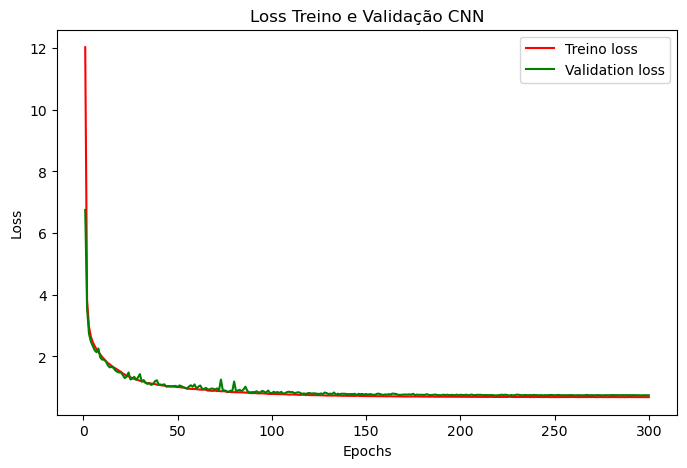

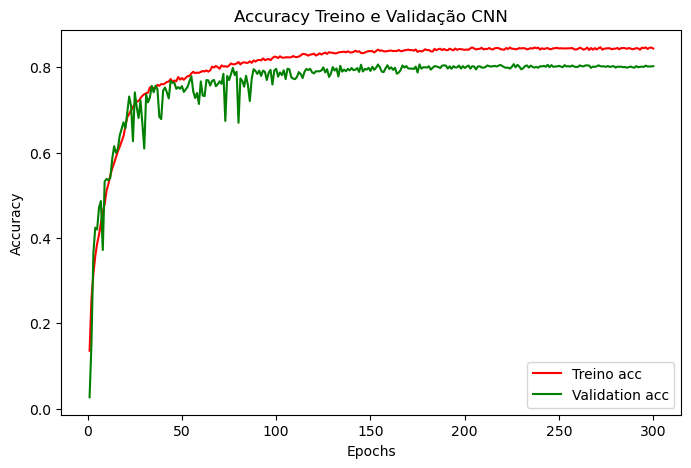

CNNAccuracy Treino: 84.379 %, Accuracy Validação: 80.23 %
CNNLoss Treino: 68.094 %, Loss Validação: 73.99 %


In [74]:
# **Plot com salvamento graficos**
loss, val_loss, acc, val_acc = plot_loss_acc(history,'CNN')

In [75]:
# **Validação da base de teste**
saida_rede = pd.DataFrame(model.predict(x_test)).round(decimals = 2)

display(saida_rede)

182/182 [==============================] - 2s 10ms/step


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.95,0.01,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.01
1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.00,0.00,0.0,0.99,0.0,0.0,0.00,0.00,0.00
2,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.71,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.14
3,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00
4,0.89,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.00,0.06,0.0,0.00,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,0.94,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,...,0.00,0.00,0.01,0.0,0.00,0.0,0.0,0.00,0.00,0.00
5804,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.33,0.00,0.00
5805,0.00,0.0,0.0,0.0,0.0,0.0,0.63,0.0,0.00,0.0,...,0.27,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.03,0.00
5806,0.56,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00


In [76]:
# **Acerto da rede**
predito   = saida_rede.idxmax(axis=1)
avaliado  = pd.DataFrame(y_test).iloc[:, 0]

resultado = list(avaliado.values - predito.values)
resultado = resultado.count(0) * 100 / len(resultado)

print("Porcentagem de acerto {}%".format(int(resultado)))

Porcentagem de acerto 81%


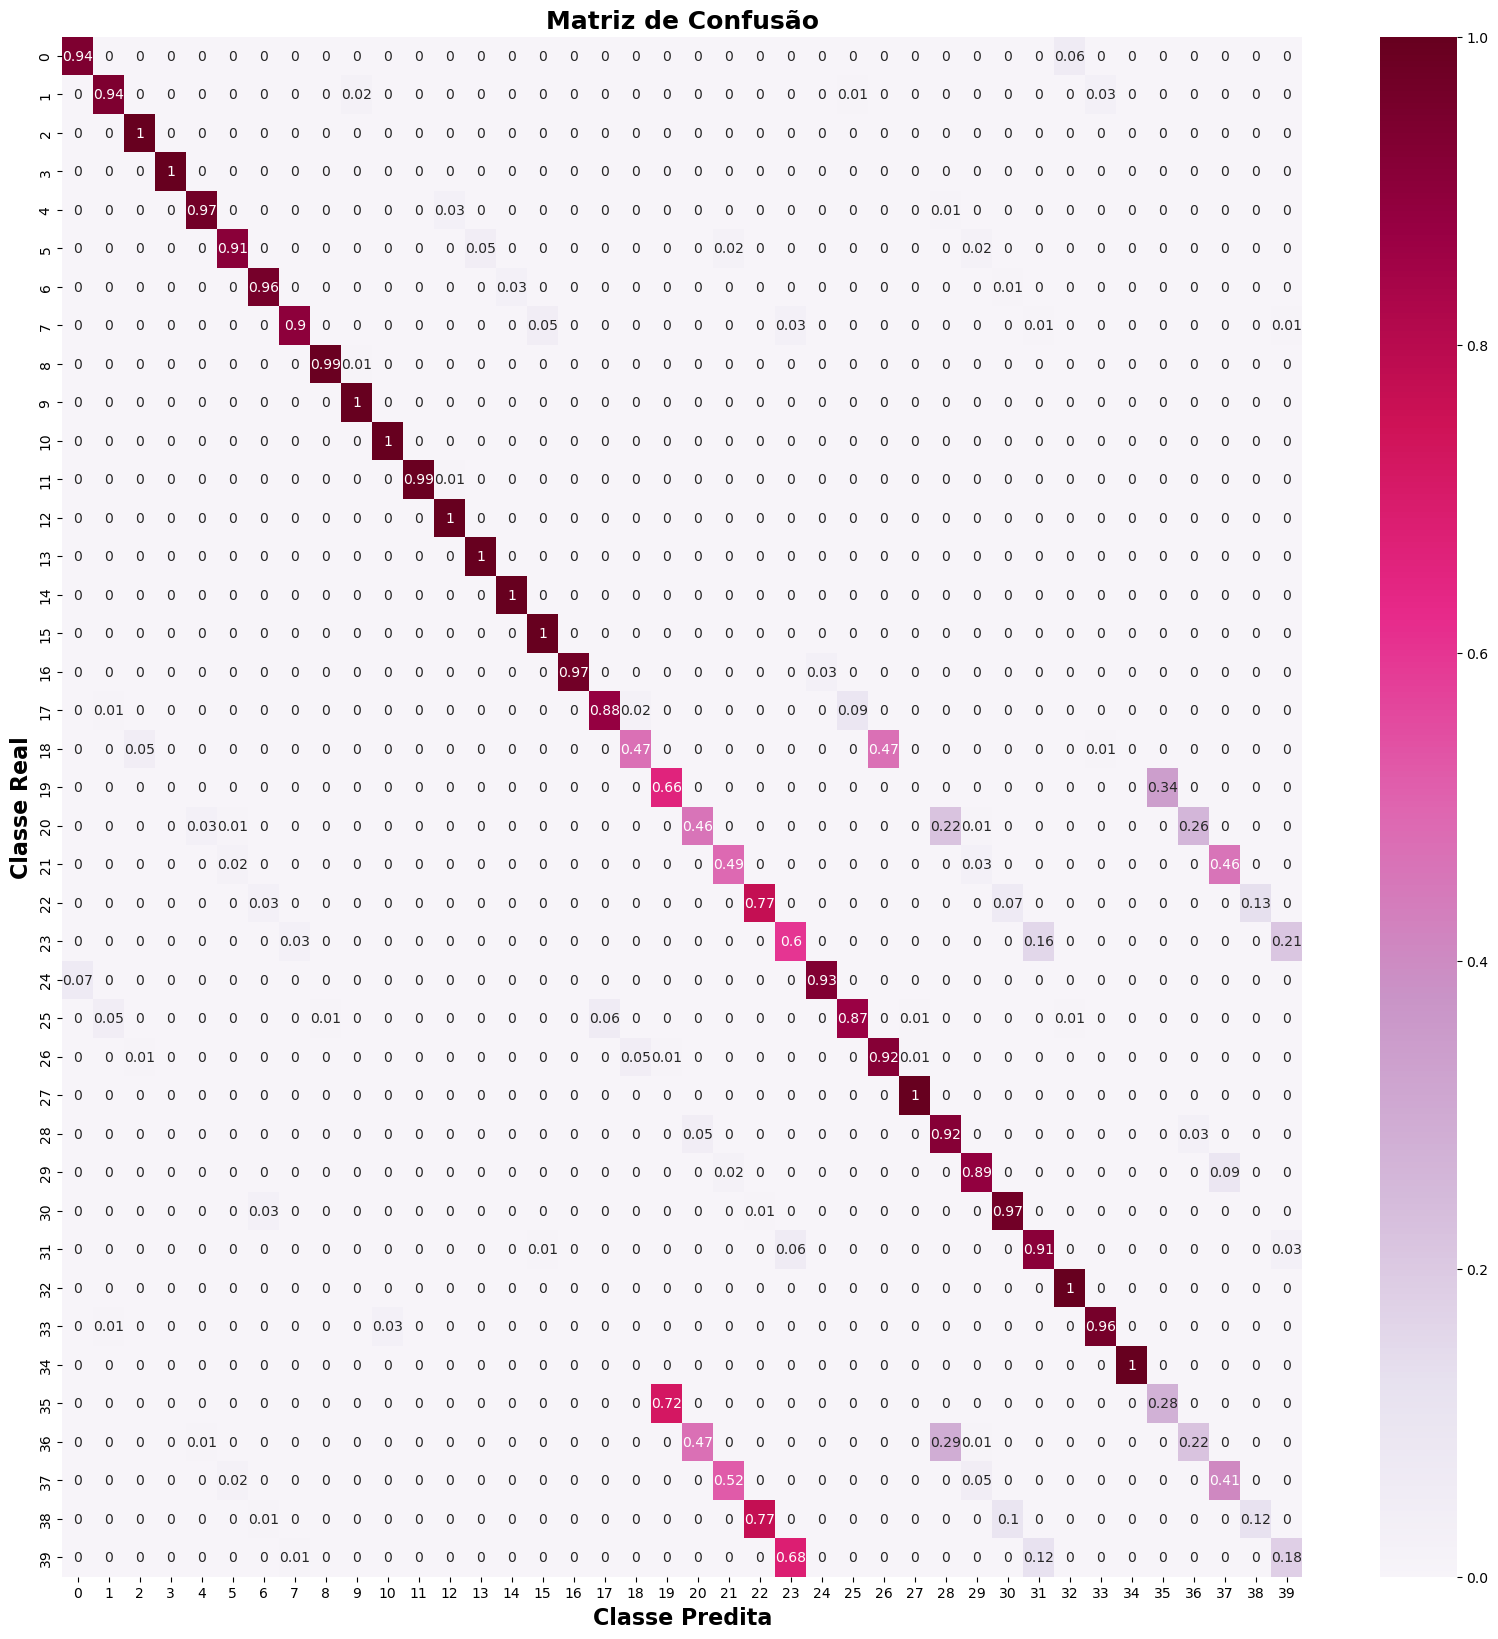

In [77]:
# **Matriz de confusão**
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(avaliado, predito)
# Normalise
cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(cmn, 
            annot=True, 
            cmap="PuRd")


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
plt.show(block=False)

In [78]:
# **Classification Report**

from sklearn.metrics import classification_report

print(classification_report(avaliado, predito))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       145
         1.0       0.94      0.94      0.94       145
         2.0       0.94      1.00      0.97       146
         3.0       1.00      1.00      1.00       146
         4.0       0.96      0.97      0.96       145
         5.0       0.95      0.91      0.93       145
         6.0       0.93      0.96      0.95       145
         7.0       0.96      0.90      0.93       145
         8.0       0.99      0.99      0.99       145
         9.0       0.97      1.00      0.98       145
        10.0       0.97      1.00      0.98       145
        11.0       1.00      0.99      1.00       145
        12.0       0.97      1.00      0.98       145
        13.0       0.95      1.00      0.98       145
        14.0       0.97      1.00      0.98       145
        15.0       0.95      1.00      0.97       145
        16.0       1.00      0.97      0.98       145
        17.0       0.93    

# Teste 3

In [79]:
# Começo da CNN
inputs = Input((x_train.shape[1],1))
    
# Primeira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=L1L2(l1=1e-5, l2=1e-4))(inputs)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
    
# Segunda camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=L1L2(l1=1e-5, l2=1e-4))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)

# Terceira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=L1L2(l1=1e-5, l2=1e-4))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
                    
# Flatten
dense = Flatten()(Conv)

# Primeira camada densa
dense = Dense(units=512, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=L1L2(l1=1e-5, l2=1e-4),
            activity_regularizer=L1L2(l1=1e-5, l2=1e-4))(dense)
dense = keras.layers.Dropout(0.05)(dense)


# Segunda camada densa
dense = Dense(units=64, 
            activation='relu',
            kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=L1L2(l1=1e-5, l2=1e-4),
            activity_regularizer=L1L2(l1=1e-5, l2=1e-4))(dense)
dense = keras.layers.Dropout(0.05)(dense)

# Camda de saída
dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
    


# instantiate and compile model
model = Model(inputs, dense)
opt = Adam(learning_rate = 0.000262)


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])



""" Callbacks """

# Check Point
checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

# Early Stopping
earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-2, patience=15, mode='auto', restore_best_weights=True)

# Reduce LR
reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, mode="auto", min_delta=1e-2, cooldown=0, min_lr=0)

        
# fit the model
history = model.fit(x_train, y_train, epochs=300,
                    validation_data=(x_validation, y_validation),
                    batch_size=64, 
                    callbacks=[[checkpoint_cb, 
                                #earlystopping, 
                                reduceLR]])
            
# Evaluate the model accuracy on the test set.
score = model.evaluate(x_test, y_test)

Epoch 1/300
424/424 [==============================] - 41s 93ms/step - loss: 2.7721 - acc: 0.2193 - val_loss: 7.6172 - val_acc: 0.0250 - lr: 2.6200e-04
Epoch 2/300
424/424 [==============================] - 38s 91ms/step - loss: 2.0734 - acc: 0.3392 - val_loss: 1.9003 - val_acc: 0.3796 - lr: 2.6200e-04
Epoch 3/300
424/424 [==============================] - 38s 91ms/step - loss: 1.8317 - acc: 0.4006 - val_loss: 1.5020 - val_acc: 0.5189 - lr: 2.6200e-04
Epoch 4/300
424/424 [==============================] - 38s 91ms/step - loss: 1.6320 - acc: 0.4568 - val_loss: 1.3807 - val_acc: 0.5281 - lr: 2.6200e-04
Epoch 5/300
424/424 [==============================] - 39s 91ms/step - loss: 1.4970 - acc: 0.4986 - val_loss: 1.2494 - val_acc: 0.5864 - lr: 2.6200e-04
Epoch 6/300
424/424 [==============================] - 40s 93ms/step - loss: 1.3762 - acc: 0.5346 - val_loss: 1.2210 - val_acc: 0.5993 - lr: 2.6200e-04
Epoch 7/300
424/424 [==============================] - 42s 98ms/step - loss: 1.2857 - ac

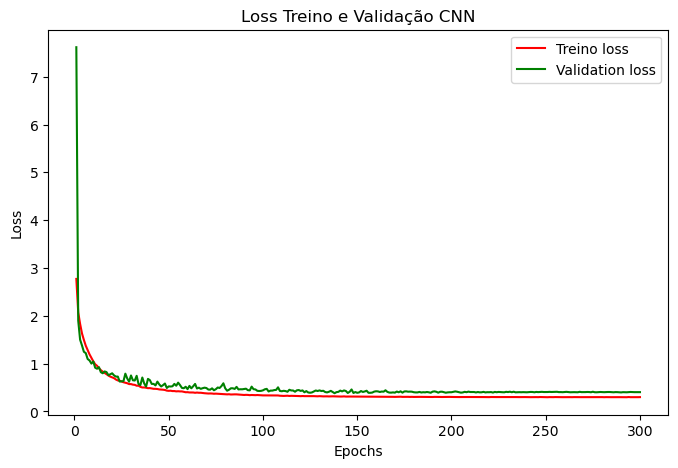

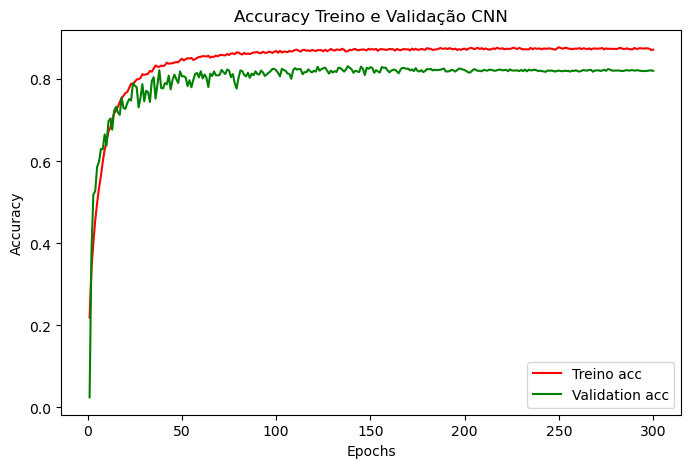

CNNAccuracy Treino: 87.249 %, Accuracy Validação: 82.08 %
CNNLoss Treino: 30.076 %, Loss Validação: 40.46 %


In [80]:
# **Plot com salvamento graficos**
loss, val_loss, acc, val_acc = plot_loss_acc(history,'CNN')

In [81]:
# **Validação da base de teste**
saida_rede = pd.DataFrame(model.predict(x_test)).round(decimals = 2)

display(saida_rede)

182/182 [==============================] - 3s 11ms/step


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.00,0.00,0.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
4,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.00,0.0
5804,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.51,0.00,0.0
5805,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
5806,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0


In [82]:
# **Acerto da rede**
predito   = saida_rede.idxmax(axis=1)
avaliado  = pd.DataFrame(y_test).iloc[:, 0]

resultado = list(avaliado.values - predito.values)
resultado = resultado.count(0) * 100 / len(resultado)

print("Porcentagem de acerto {}%".format(int(resultado)))

Porcentagem de acerto 82%


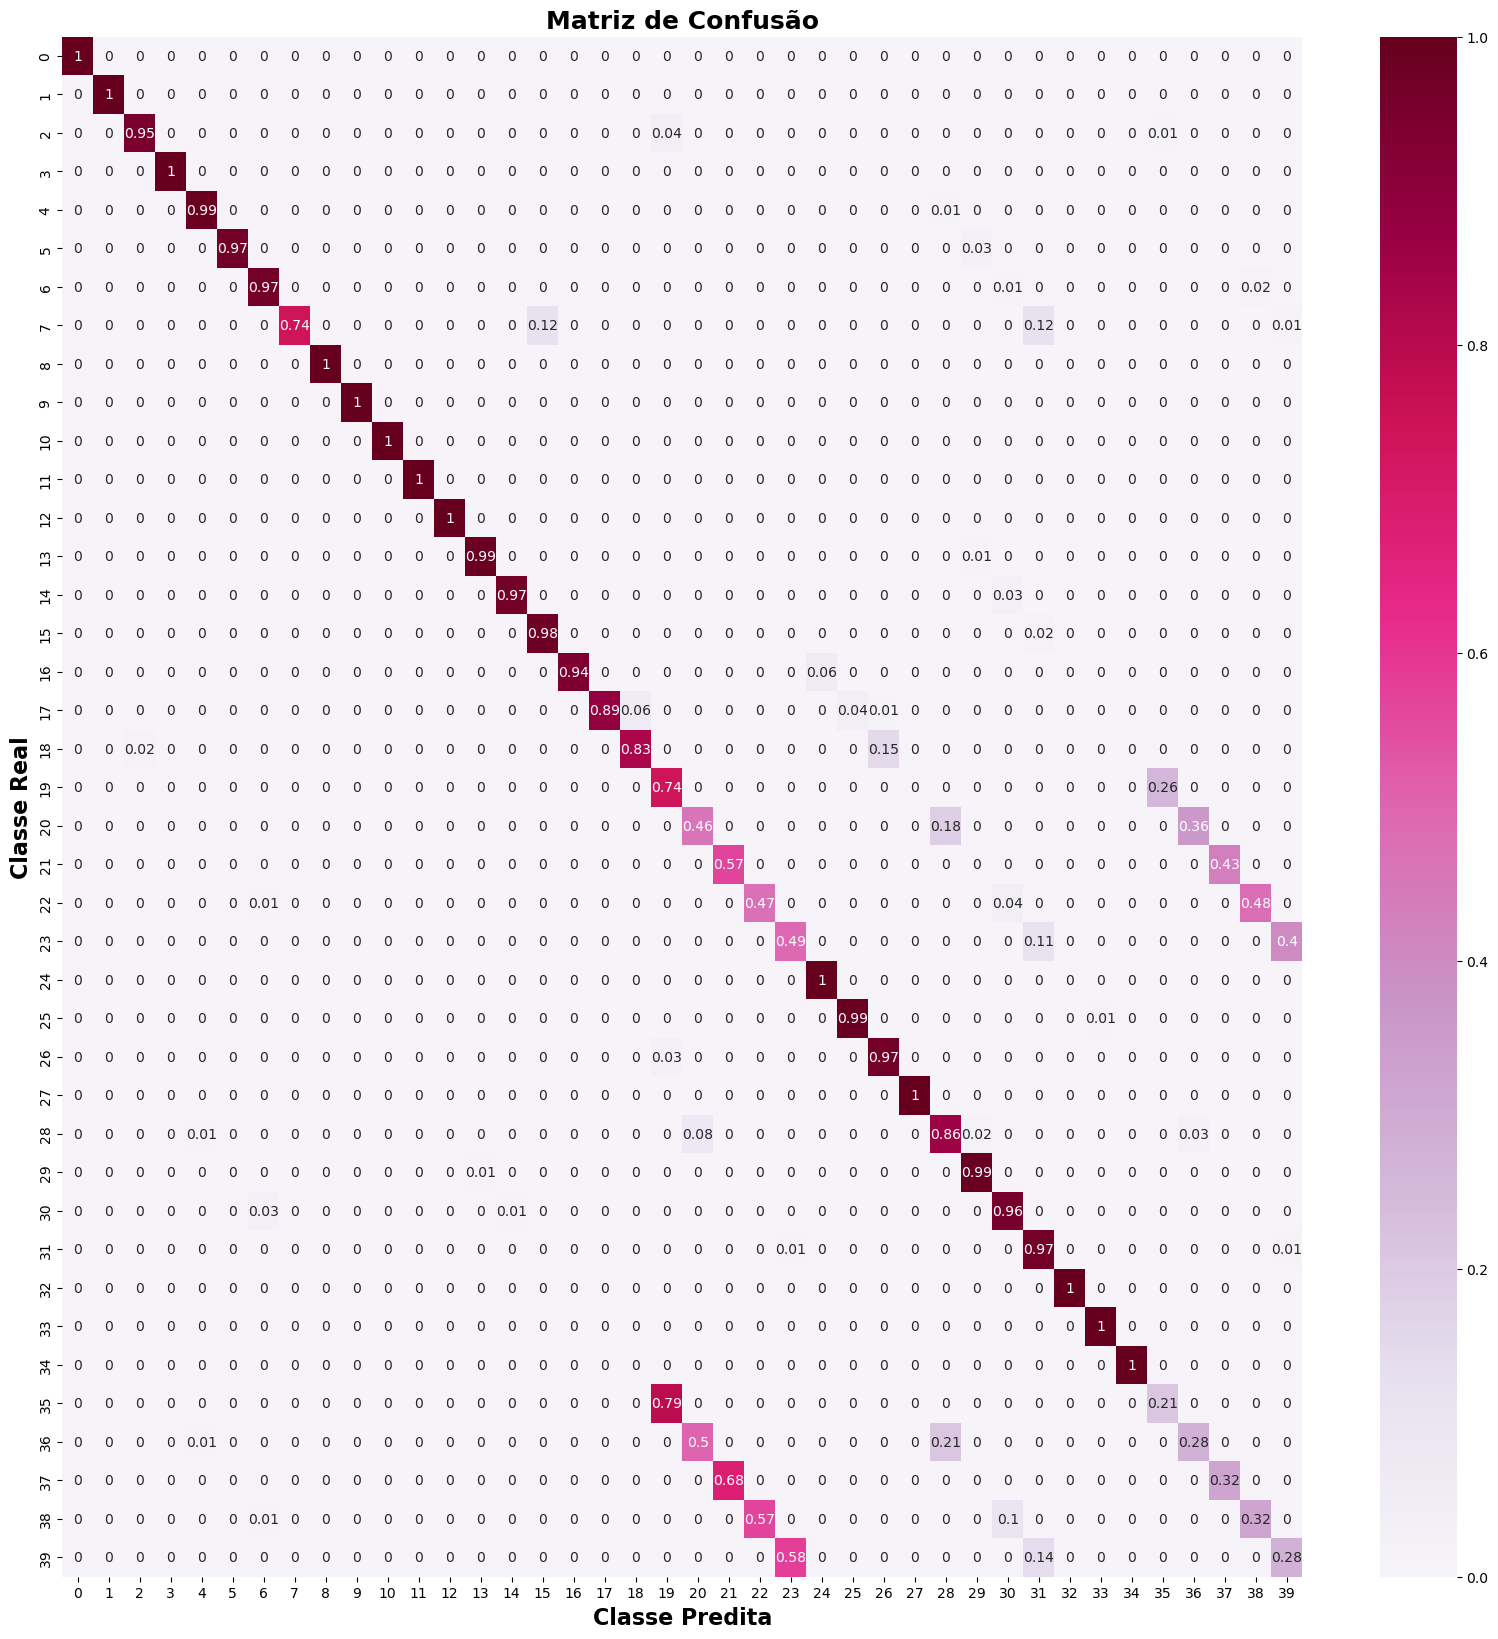

In [83]:
# **Matriz de confusão**
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(avaliado, predito)
# Normalise
cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(cmn, 
            annot=True, 
            cmap="PuRd")


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
plt.show(block=False)

In [84]:
# **Classification Report**

from sklearn.metrics import classification_report

print(classification_report(avaliado, predito))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       145
         1.0       1.00      1.00      1.00       145
         2.0       0.98      0.95      0.97       146
         3.0       1.00      1.00      1.00       146
         4.0       0.99      0.99      0.99       145
         5.0       1.00      0.97      0.99       145
         6.0       0.95      0.97      0.96       145
         7.0       1.00      0.74      0.85       145
         8.0       1.00      1.00      1.00       145
         9.0       1.00      1.00      1.00       145
        10.0       1.00      1.00      1.00       145
        11.0       1.00      1.00      1.00       145
        12.0       1.00      1.00      1.00       145
        13.0       0.99      0.99      0.99       145
        14.0       0.99      0.97      0.98       145
        15.0       0.89      0.98      0.93       145
        16.0       1.00      0.94      0.97       145
        17.0       1.00    